# Accident-Prone Zone Detection using Computer Vision
(Offline Video-Frame Analysis)


## Environment Setup
This cell installs all the required Python libraries for computer vision, object detection, and data analysis.


In [65]:
!pip install ultralytics opencv-python matplotlib pandas numpy


## Import Required Libraries
This cell imports the necessary libraries for video processing, data handling, visualization, and YOLO-based object detection.


In [66]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO


## Project Directory Initialization
This cell creates the required folders to organize videos, extracted frames, and output results.


In [67]:
import os

os.makedirs("videos", exist_ok=True)
os.makedirs("frames", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

print("Folders created successfully!")

os.listdir("frames")
os.listdir("videos")
os.listdir("outputs")




Folders created successfully!


['risk_frame_6.jpg',
 'risk_frame_15.jpg',
 'frame_14.jpg',
 'risk_frame_9.jpg',
 'risk_frame_11.jpg',
 'frame_10.jpg',
 'frame_11.jpg',
 'risk_frame_2.jpg',
 'frame_9.jpg',
 'frame_12.jpg',
 'frame_0.jpg',
 'frame_8.jpg',
 'frame_4.jpg',
 'risk_frame_3.jpg',
 'risk_frame_8.jpg',
 'risk_frame_7.jpg',
 'risk_frame_5.jpg',
 'frame_5.jpg',
 'risk_frame_4.jpg',
 'frame_15.jpg',
 'risk_frame_12.jpg',
 'frame_2.jpg',
 'frame_13.jpg',
 'frame_7.jpg',
 'frame_1.jpg',
 'risk_frame_13.jpg',
 'risk_frame_0.jpg',
 'risk_frame_10.jpg',
 'risk_frame_14.jpg',
 'annotated_frames',
 'frame_6.jpg',
 'frame_3.jpg',
 'risk_frame_1.jpg']

## Load Object Detection Model
This cell loads a pre-trained YOLOv8 model for detecting vehicles and pedestrians in traffic scenes.


In [68]:
model = YOLO("yolov8n.pt")
print("YOLO model loaded!")


YOLO model loaded!


## Extract Frames from Traffic Video
This cell extracts frames from the traffic video at regular intervals to enable frame-wise object detection and analysis.


In [69]:
import cv2

video_path = "videos/traffic.mp4"   # change name if needed
cap = cv2.VideoCapture(video_path)

frame_count = 0
saved_count = 0
fps_interval = int(cap.get(cv2.CAP_PROP_FPS)) # 1 frame per second (if video is ~30 FPS)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % fps_interval == 0:
        frame_name = f"frames/frame_{saved_count}.jpg"
        cv2.imwrite(frame_name, frame)
        saved_count += 1

    frame_count += 1

cap.release()
print(f"{saved_count} frames extracted and saved!")


16 frames extracted and saved!


## Object Detection and Risk Scoring
This cell applies object detection on each extracted frame, counts vehicles and pedestrians, and computes a frame-level accident risk score based on traffic density.


In [70]:
import pandas as pd
import os

detections_summary = []

for img_name in sorted(os.listdir("frames")):
    img_path = os.path.join("frames", img_name)

    results = model(img_path, conf=0.4)

    vehicle_count = 0
    pedestrian_count = 0
    risk_score = 0

    # Count detected objects
    for r in results:
        for box in r.boxes:
            cls = int(box.cls[0])
            label = model.names[cls]

            if label in ["car", "bus", "truck", "motorcycle"]:
                vehicle_count += 1
            elif label == "person":
                pedestrian_count += 1

    # -------- Upgrade 3: Risk Scoring Logic --------
    if vehicle_count > 8:
        risk_score += 2
    elif vehicle_count > 4:
        risk_score += 1

    if pedestrian_count > 3:
        risk_score += 2
    elif pedestrian_count > 1:
        risk_score += 1

    if risk_score >= 4:
        risk_label = "High"
    elif risk_score >= 2:
        risk_label = "Medium"
    else:
        risk_label = "Low"

    # Store results for this frame
    detections_summary.append({
        "frame": img_name,
        "vehicle_count": vehicle_count,
        "pedestrian_count": pedestrian_count,
        "risk_score": risk_score,
        "risk_label": risk_label
    })

df = pd.DataFrame(detections_summary)
df.head()
assert not df.empty, "No detections found in frames"




image 1/1 /content/frames/frame_0.jpg: 640x640 3 cars, 1 truck, 534.3ms
Speed: 12.5ms preprocess, 534.3ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/frames/frame_1.jpg: 640x640 5 cars, 436.6ms
Speed: 15.5ms preprocess, 436.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/frames/frame_10.jpg: 640x640 1 car, 289.4ms
Speed: 6.4ms preprocess, 289.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/frames/frame_11.jpg: 640x640 1 car, 1 airplane, 1 truck, 372.8ms
Speed: 8.9ms preprocess, 372.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/frames/frame_12.jpg: 640x640 1 train, 261.3ms
Speed: 6.4ms preprocess, 261.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/frames/frame_13.jpg: 640x640 1 car, 1 airplane, 492.8ms
Speed: 6.8ms preprocess, 492.8ms inference, 2.2ms postprocess per image at shape

## Verify Detection Data Columns
This cell checks the structure of the DataFrame to ensure all required detection and risk columns are present before further analysis.


In [71]:
print(df.columns)


Index(['frame', 'vehicle_count', 'pedestrian_count', 'risk_score',
       'risk_label'],
      dtype='object')


## Accident Risk Trend Visualization
This cell visualizes how accident risk varies across video frames using a line plot.


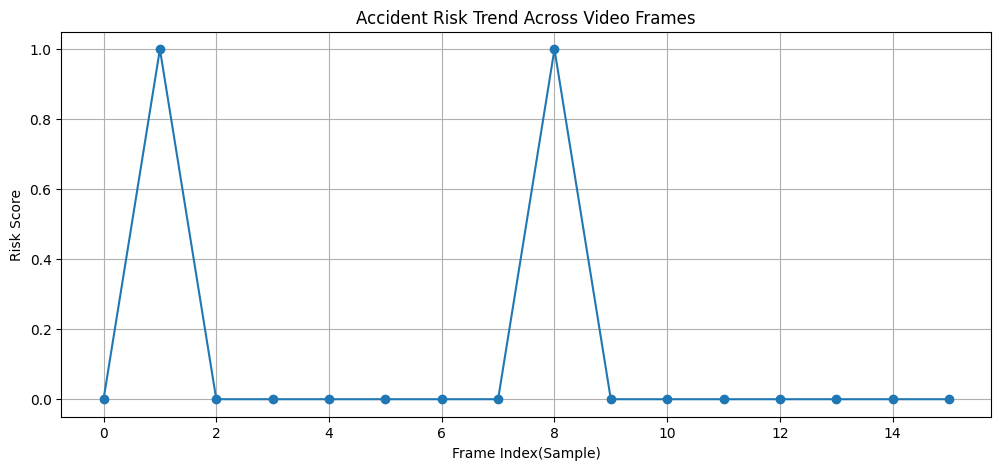

In [72]:
plt.figure(figsize=(12,5))
plt.plot(df["risk_score"], marker="o")
plt.title("Accident Risk Trend Across Video Frames")
plt.xlabel("Frame Index(Sample)")
plt.ylabel("Risk Score")
plt.grid(True)
plt.show()


## Risk Score Distribution Analysis
This cell visualizes the frequency distribution of accident risk scores across all processed frames.


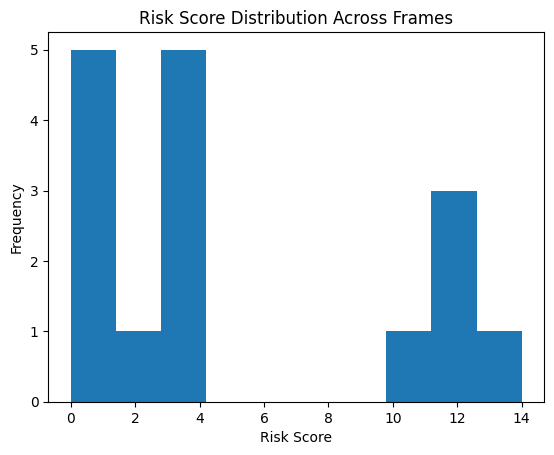

In [73]:
import numpy as np

# Convert risk scores to array
risk_array = np.array(risk_scores)

plt.figure()
plt.hist(risk_array, bins=10)
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.title("Risk Score Distribution Across Frames")
plt.show()


## Sample Frame Detection Visualization
This cell visualizes object detection results on a sample frame to demonstrate YOLO’s detection accuracy.



image 1/1 /content/frames/frame_0.jpg: 640x640 3 cars, 2 trucks, 567.3ms
Speed: 8.7ms preprocess, 567.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)


(np.float64(-0.5), np.float64(1079.5), np.float64(1079.5), np.float64(-0.5))

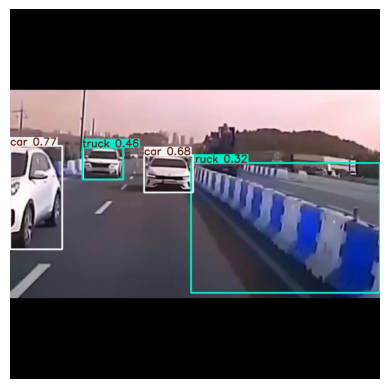

In [74]:
image_path = "frames/frame_0.jpg"
results = model(image_path)

annotated = results[0].plot()
plt.imshow(annotated)
plt.axis("off")


## Annotated Frame Visualization
This cell generates annotated traffic frames using object detection for visual demonstration purposes only.
It does not contribute to risk computation or analysis.


In [75]:
import os

frame_files = os.listdir("frames")

vehicle_classes = [2, 3, 5, 7]  # car, motorcycle, bus, truck
pedestrian_class = 0

for frame_file in frame_files:
    frame_path = os.path.join("frames", frame_file)
    image = cv2.imread(frame_path)

    results = model(image)[0]

    vehicle_count = 0
    pedestrian_count = 0

    for box in results.boxes:
        cls = int(box.cls[0])

        if cls in vehicle_classes:
            vehicle_count += 1
        elif cls == pedestrian_class:
            pedestrian_count += 1

    annotated_frame = results.plot()

    output_path = os.path.join("outputs", frame_file)
    cv2.imwrite(output_path, annotated_frame)

    print(f"{frame_file} → Vehicles: {vehicle_count}, Pedestrians: {pedestrian_count}")



0: 640x640 (no detections), 357.1ms
Speed: 13.0ms preprocess, 357.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
frame_14.jpg → Vehicles: 0, Pedestrians: 0

0: 640x640 2 cars, 278.9ms
Speed: 15.2ms preprocess, 278.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
frame_10.jpg → Vehicles: 2, Pedestrians: 0

0: 640x640 1 car, 1 airplane, 1 truck, 271.5ms
Speed: 6.6ms preprocess, 271.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
frame_11.jpg → Vehicles: 2, Pedestrians: 0

0: 640x640 2 trucks, 1 traffic light, 261.2ms
Speed: 5.3ms preprocess, 261.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
frame_9.jpg → Vehicles: 2, Pedestrians: 0

0: 640x640 1 train, 250.4ms
Speed: 6.0ms preprocess, 250.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
frame_12.jpg → Vehicles: 0, Pedestrians: 0

0: 640x640 3 cars, 2 trucks, 258.1ms
Speed: 5.2ms preprocess, 258.1ms inference, 1.9ms postprocess per i

## Risk Level Classification
This cell categorizes accident risk into Low, Medium, and High levels using rule-based thresholds on detected traffic density.


In [76]:
def calculate_risk(v, p):
    score = 0
    if v > 10:
        score += 2
    if p > 5:
        score += 2
    if v > 15 and p > 8:
        score += 3

    if score <= 2:
        return "Low"
    elif score <= 4:
        return "Medium"
    else:
        return "High"

df["risk_level"] = df.apply(
    lambda x: calculate_risk(x["vehicle_count"], x["pedestrian_count"]),
    axis=1
)
df.head()


,frame,vehicle_count,pedestrian_count,risk_score,risk_label,risk_level
0,frame_0.jpg,4,0,0,Low,Low
1,frame_1.jpg,5,0,1,Low,Low
2,frame_10.jpg,1,0,0,Low,Low
3,frame_11.jpg,2,0,0,Low,Low
4,frame_12.jpg,0,0,0,Low,Low


## Risk Level Trend Visualization
This cell converts categorical risk levels into numerical values to visualize overall accident risk trends across frames.


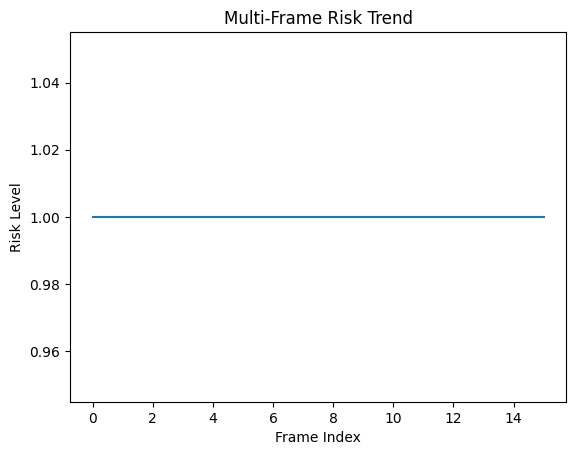

In [77]:
import matplotlib.pyplot as plt

risk_map = {"Low": 1, "Medium": 2, "High": 3}
df["risk_level_numeric"] = df["risk_level"].map(risk_map)

plt.figure()
plt.plot(df.index, df["risk_level_numeric"])
plt.xlabel("Frame Index")
plt.ylabel("Risk Level")
plt.title("Multi-Frame Risk Trend")
plt.show()


## Single-Frame Risk Validation
This cell validates the risk classification logic on a single frame by computing vehicle and pedestrian counts manually.


In [78]:
image = cv2.imread("frames/frame_0.jpg")
results = model(image)
detections = results[0].boxes.cls.cpu().numpy()

vehicle_count = np.sum((detections == 2) | (detections == 3) | (detections == 5))
pedestrian_count = np.sum(detections == 0)

risk = calculate_risk(vehicle_count, pedestrian_count)

print("Vehicles:", vehicle_count)
print("Pedestrians:", pedestrian_count)
print("Risk Level:", risk)



0: 640x640 3 cars, 2 trucks, 244.6ms
Speed: 5.4ms preprocess, 244.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Vehicles: 3
Pedestrians: 0
Risk Level: Low


## Traffic Risk Heatmap
This cell visualizes traffic density and accident risk across frames using a heatmap representation.


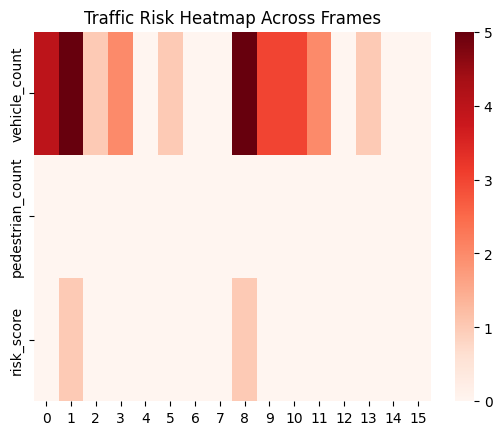

In [79]:
import seaborn as sns

plt.figure()
sns.heatmap(
    df[["vehicle_count", "pedestrian_count", "risk_score"]].T,
    cmap="Reds"
)
plt.title("Traffic Risk Heatmap Across Frames")
plt.show()


## Risk-Based Frame Annotation
This cell applies the accident risk classification to each frame and overlays the computed risk level directly onto the annotated frames for intuitive visual interpretation.


In [80]:
import cv2
import os

risk_summary = []

for frame_file in frame_files:
    frame_path = os.path.join("frames", frame_file)
    image = cv2.imread(frame_path)

    # Run YOLO detection
    results = model(image)[0]

    vehicles = 0
    pedestrians = 0

    # Count detected objects
    for box in results.boxes:
        cls = int(box.cls[0])
        if cls in vehicle_classes:
            vehicles += 1
        elif cls == pedestrian_class:
            pedestrians += 1

    # Calculate risk level
    risk = calculate_risk(vehicles, pedestrians)
    risk_summary.append(risk)

    # Choose color based on risk level
    if risk == "Low":
        color = (0, 255, 0)      # Green
    elif risk == "Medium":
        color = (0, 255, 255)   # Yellow
    else:
        color = (0, 0, 255)     # Red

    # Draw bounding boxes
    annotated = results.plot()

    # Overlay risk text on frame
    cv2.putText(
        annotated,
        f"RISK: {risk}",
        (30, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        color,
        2
    )

    # Save annotated frame
    output_path = os.path.join("outputs", f"risk_{frame_file}")
    cv2.imwrite(output_path, annotated)

print("Risk-annotated frames saved successfully.")



0: 640x640 (no detections), 241.1ms
Speed: 4.9ms preprocess, 241.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 cars, 255.7ms
Speed: 5.8ms preprocess, 255.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 1 airplane, 1 truck, 241.2ms
Speed: 10.2ms preprocess, 241.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 trucks, 1 traffic light, 258.9ms
Speed: 6.0ms preprocess, 258.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 train, 242.7ms
Speed: 5.7ms preprocess, 242.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 cars, 2 trucks, 238.8ms
Speed: 6.0ms preprocess, 238.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 airplane, 233.8ms
Speed: 5.4ms preprocess, 233.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 cars, 2 trucks, 256.3ms
Speed: 6.1ms pre

(np.float64(-0.5), np.float64(1079.5), np.float64(1079.5), np.float64(-0.5))

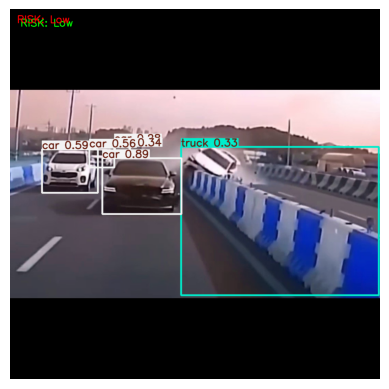

In [81]:
assert annotated is not None, "Annotated frame not found. Run Cell 18 first."
cv2.putText(
    annotated,
    f"RISK: {risk}",
    (20, 40),
    cv2.FONT_HERSHEY_SIMPLEX,
    1,
    (255, 0, 0),
    2
)

plt.imshow(annotated)
plt.axis("off")


## Risk Distribution Across Frames
This cell summarizes the frequency of Low, Medium, and High risk frames to understand overall traffic safety patterns.


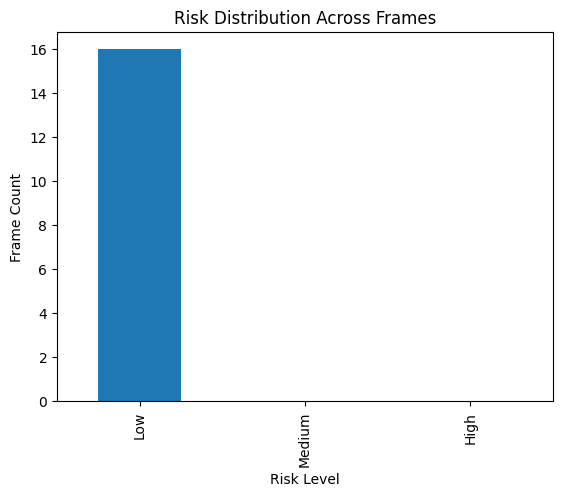

In [82]:
import pandas as pd

df = pd.DataFrame({
    "Frame": frame_files,
    "Risk": risk_summary
})

df["Risk"].value_counts().reindex(["Low", "Medium", "High"]).plot(kind="bar")
plt.title("Risk Distribution Across Frames")
plt.xlabel("Risk Level")
plt.ylabel("Frame Count")
plt.show()


## Results Summary

The system successfully analyzed traffic video frames and identified
potentially accident-prone zones using vehicle density and pedestrian presence.

Frame-wise risk analysis highlights dynamic traffic risk patterns, demonstrating
how computer vision can support preventive and ethical traffic safety analysis
in offline monitoring scenarios.


## Project Abstract

Road traffic accidents are a critical public safety challenge influenced by vehicle congestion and pedestrian density. This project presents a computer vision–based system to identify accident-prone zones through offline analysis of traffic video frames.

A YOLO-based object detection model is used to detect vehicles and pedestrians, followed by an explainable rule-based risk scoring mechanism that classifies each frame into Low, Medium, or High risk levels. Traffic risk patterns are analyzed using trend plots, heatmaps, and risk distributions.

Annotated traffic frames with color-coded risk overlays provide intuitive qualitative verification of detection performance. The project emphasizes ethical, non-real-time analysis using public visual data, demonstrating the potential of computer vision for preventive traffic safety assessment.
